# Сборный проект - 2

## Описание проекта

Компания «Работа с заботой» помогает бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Описание данных:**

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.


## Подключение библиотек и установка констант

In [1]:
!pip install phik
!pip install shap
!pip install lightgbm
!pip install -U scikit-learn

import warnings
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import shap


from lightgbm import LGBMRegressor, LGBMClassifier
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


from scipy import stats as st
from scipy.stats import gaussian_kde,shapiro

     |████████████████████████████████| 686 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 540 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 13.4 MB 1.1 MB/s eta 0:00:01    |████████▌                       | 3.6 MB 1.1 MB/s eta 0:00:10
     |████████████████████████████████| 301 kB 93.0 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Шаг 1. Загрузка данных

In [5]:
train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

#### Проверяем данные на соответсвие описанию

In [6]:
def data_info(data):
    try:
        display('Первые пять строк данных:')
        display(data.head())
        print('\n-----------------------------\n')
        display('Последние пять строк данных:')
        display(data.tail())
        print('\n-----------------------------\n')
        display('Общая информация о датафрейме')
        data.info()
        print('\n-----------------------------\n')
        display('Описание данных:')
        display(data.drop(columns = ['id']).describe())
        print('\n-----------------------------\n')
        display('Количество пропусков')
        display(data.isna().sum())
        print('\n-----------------------------\n')
        display('Количество явных дубликатов')
        display(data.duplicated().sum())
       
    except:
        return 'Ошибка'

**train**

In [7]:
data_info(train)

'Первые пять строк данных:'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



-----------------------------



'Последние пять строк данных:'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48
3999,338347,technology,middle,medium,5,no,yes,1,44400,0.18



-----------------------------



'Общая информация о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

-----------------------------



'Описание данных:'

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000



-----------------------------



'Количество пропусков'

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


-----------------------------



'Количество явных дубликатов'

0

**test_features**

In [8]:
data_info(test_features)

'Первые пять строк данных:'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



-----------------------------



'Последние пять строк данных:'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400
1999,771859,purchasing,middle,medium,1,no,no,4,38400



-----------------------------



'Общая информация о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

-----------------------------



'Описание данных:'

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000



-----------------------------



'Количество пропусков'

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


-----------------------------



'Количество явных дубликатов'

0

**test_target**

In [9]:
data_info(test_target)

'Первые пять строк данных:'

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08



-----------------------------



'Последние пять строк данных:'

,id,job_satisfaction_rate
1995,405257,0.28
1996,370925,0.21
1997,857722,0.39
1998,303402,0.26
1999,648995,0.62



-----------------------------



'Общая информация о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB

-----------------------------



'Описание данных:'

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000



-----------------------------



'Количество пропусков'

id                       0
job_satisfaction_rate    0
dtype: int64


-----------------------------



'Количество явных дубликатов'

0

#### Вывод

---

- **`train`**
    - Всего в датасете 4000 записей
    - Есть пропущенные значения в столбцах `dept` (6) и `level` (4)
    - Явные дубликаты не обнаружены
    - Предварительно, аномальных значений не обнаружено 
    - С типами данных все в порядке

- **`test_features`**
    - Всего в датасете 2000 записей
    - Есть пропущенные значения в столбцах `dept` (2) и `level` (1)
    - Явные дубликаты не обнаружены
    - Предварительно, аномальных значений не обнаружено 
    - С типами данных все в порядке


- **`test_target`**
    - Всего в датасете 2000 записей
    - Пропущенных значений не обнаружено
    - Явные дубликаты не обнаружены
    - Предварительно, аномальных значений не обнаружено 
    - С типами данных все в порядке
    
---

### Шаг 2. Предоработка данных

Что бы избавиться от пропусков используем SimpleImputer() который сразу поместим в пайплайн.

In [10]:
# Пайплайн для замены пропущенных значений
imputer_pipe = Pipeline(
    [
        (
            'SimpleImputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

#### train

Выведем словарь, где ключ - название столбца, а значение -список уникальных значений столбца.

In [11]:
[{i: list(train[i]
          .unique())} for i in train.columns if train[i].dtype == 'object']

[{'dept': ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan]},
 {'level': ['junior', 'middle', 'sinior', nan]},
 {'workload': ['medium', 'high', 'low']},
 {'last_year_promo': ['no', 'yes']},
 {'last_year_violations': ['no', 'yes']}]

Наблюдаем ошибку в слове senior - исправим

In [12]:
train['level'].replace({'sinior': 'senior'}, inplace=True)

Вывод строк с пропусками:

In [13]:
train[train['dept'].isnull() | train['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [15]:
train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Пропуски успешно заменены.

#### test_features

Выведем словарь, где ключ - название столбца, а значение -список уникальных значений столбца.

In [16]:
[{i: list(test_features[i]
          .unique())} for i in test_features.columns if test_features[i].dtype == 'object']

[{'dept': ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' ']},
 {'level': ['junior', 'middle', 'sinior', nan]},
 {'workload': ['medium', 'low', 'high', ' ']},
 {'last_year_promo': ['no', 'yes']},
 {'last_year_violations': ['no', 'yes']}]

In [17]:
test_features['level'].replace({'sinior': 'senior'}, inplace=True)

Ознакомимся с пустыми значениями внимательней

In [18]:
test_features.query('dept == " "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [19]:
test_features['dept'].replace({' ': np.nan}, inplace=True)

In [20]:
test_features.query('workload == " "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [21]:
test_features.replace({' ': np.nan}, inplace=True)

In [23]:
test_features.isna().sum()

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Пропуски будут заменены пайплайном далее.

#### Вывод

---
- `train`:
    - Исправили орфографическую ошибку *sinior -> senior* в столбце `level`
    - Заменили пропущенные значения при помощи пайплайна (`SimpleImputer`)

- `test_features`:
    - Исправили орфографическую ошибку *sinior -> senior* в столбце `level`
    - Заменили пустые строки (" ") из данных на пропущенные значения
    - Заменили пропущенные значения при помощи пайплайна (`SimpleImputer`)


- `job_y_test`:
    - С датасетом все в порядке


---

### Шаг 2. Исследовательский анализ данных

In [24]:
# Строит гистограммы и ящики с усами для каждого количественного фактора

def plot_combined_analysis(df, feature, title):
    
    n = df[feature].dropna().shape[0]
    bins = int(np.log2(n) + 1)



    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
    fig.suptitle(title, fontsize=16)

    # Гистограмма с KDE
    sns.histplot(df[feature], kde=True, bins=bins, ax=ax[0])
    ax[0].set_title('Histogram with KDE', fontsize=15)
    ax[0].set_xlabel(feature)
    ax[0].set_ylabel('Frequency')

    # Ящик с усами (Boxplot)
    sns.boxplot(x=df[feature], ax=ax[1])
    ax[1].set_title('Boxplot', fontsize=15)
    ax[1].set_xlabel(None)

    # Тест на нормальность и QQ-Plot
    
    st.probplot(df[feature], dist="norm", plot=ax[2])
    ax[2].set_title('QQ Plot', fontsize=15)

    # Тест Шапиро-Уилка
    stat, p = shapiro(df[feature].dropna())
    alpha = 0.05  # Уровень значимости
    if p > alpha:
        normality_result = "Распределение похоже на нормальное"
    else:
        normality_result = "Распределение отличается от нормального"

    plt.figtext(0.5, -0.05, f"По тесту Шапиро-Уилка: {normality_result}", wrap=True, horizontalalignment='center', fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [25]:
def plot_countplots(df):
  
    # Выбор категориальных столбцов
    cat_col_names = df.select_dtypes(exclude=['number']).columns

    # Установка размера фигуры
    num_plots = len(cat_col_names)
    plt.figure(figsize=(10, 5 * num_plots))



    # Построение countplots для каждого категориального столбца
    for i, col in enumerate(cat_col_names):
        plt.subplot(num_plots, 1, i + 1)
        ax = sns.countplot(y=col, data=df)
        
        # Добавление процентных подписей
        total = len(df)
        for p in ax.patches:
            width = p.get_width()
            percentage = 100 * width / total
            ax.text(width + 1, p.get_y() + p.get_height() / 2, f'{percentage:.1f}%', ha='center', va='center')

        plt.title(f'График {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')

    plt.tight_layout()
    plt.show()

#### train

**Статистический анализ количественных данных**

In [26]:
train.drop(columns = ['id']).describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


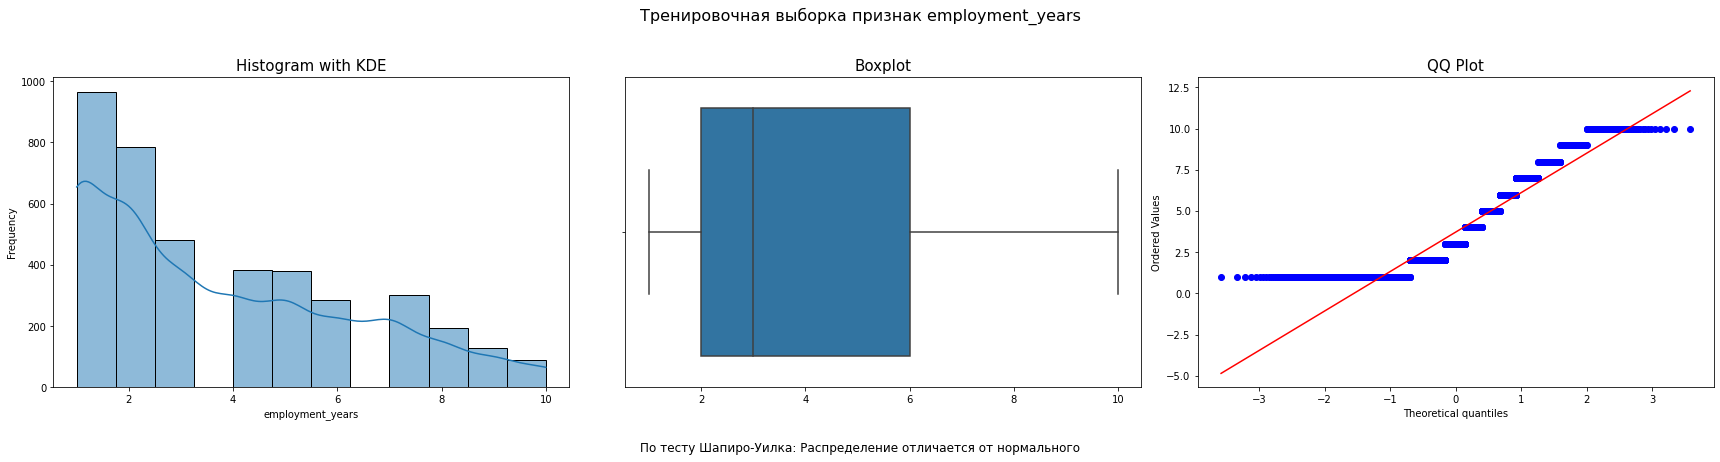

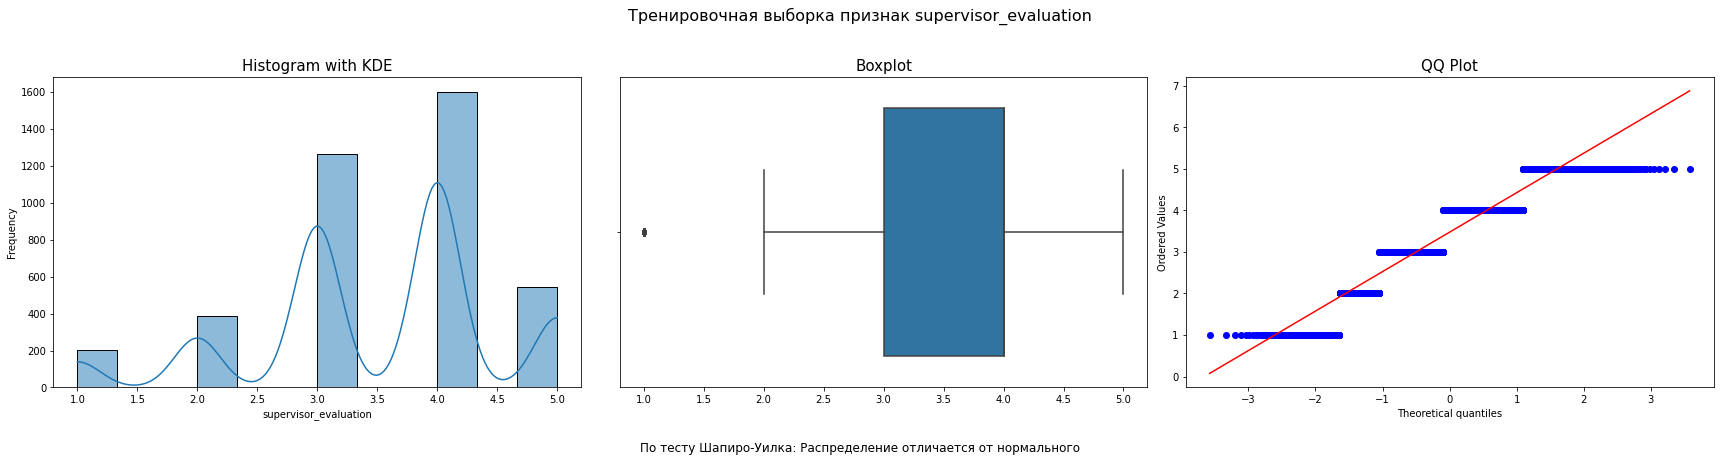

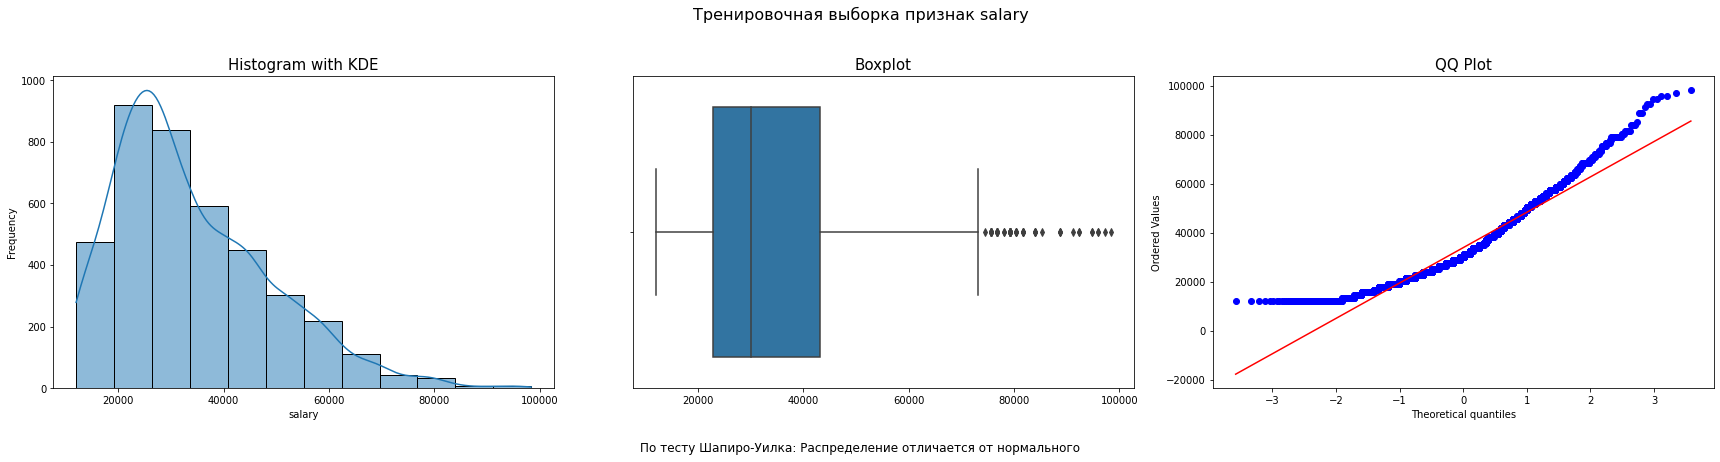

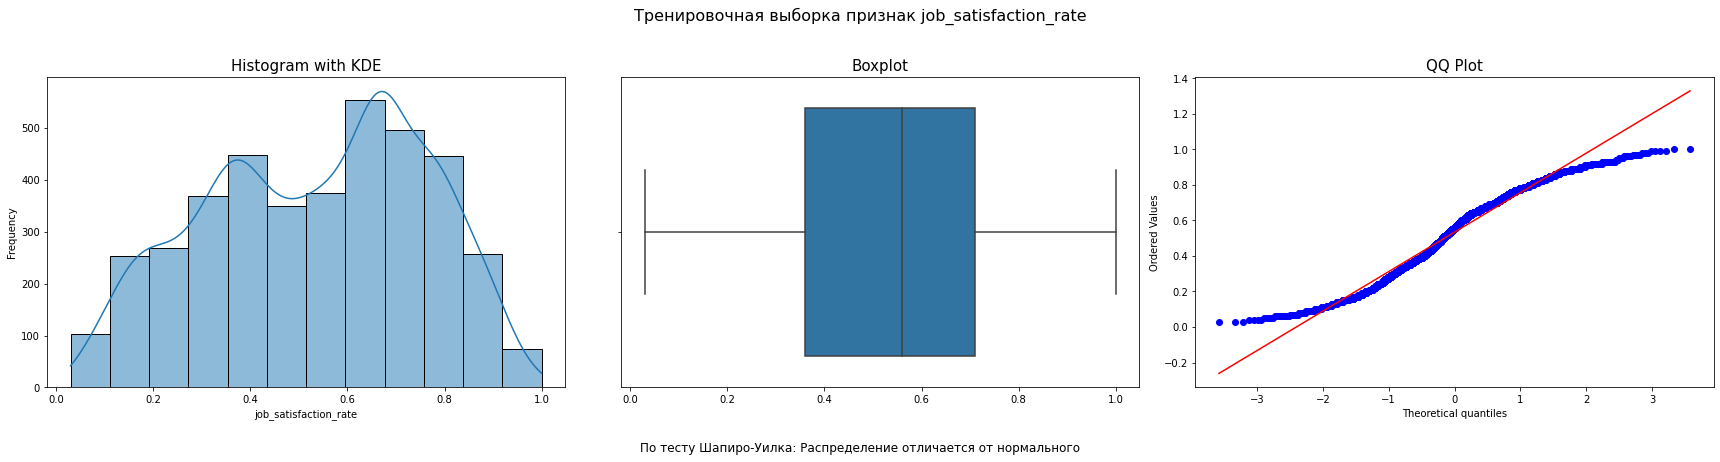

In [27]:
feats = train.drop(columns = ['id']).select_dtypes(include='number').columns.tolist()
for i in feats:
    plot_combined_analysis(train, i, f'Тренировочная выборка признак {i}')

 - В компании практически в 2 раза больше сотрудников, которые работают в ней до 3х лет: опытных сотрудников гораздо меньше.  Что говорит о дисбалансе, это нужно будет учесть при моделировании.
 - Самая частая оценка качества работы сотрудника, которую давал руководитель - 4. 
 - Медианная зарплата в компании - **30 000**. На ящике с усами видны выбросы, однако убирать их не будем в связи с их небольшим количеством и репрезентативностью высоких зарплат сотрудников. Будем применять масштабирование в дальнейшем.
 - Целевой признак распределен близко к нормальному с двумя пиковыми значениями

**Анализ категориальных данных**

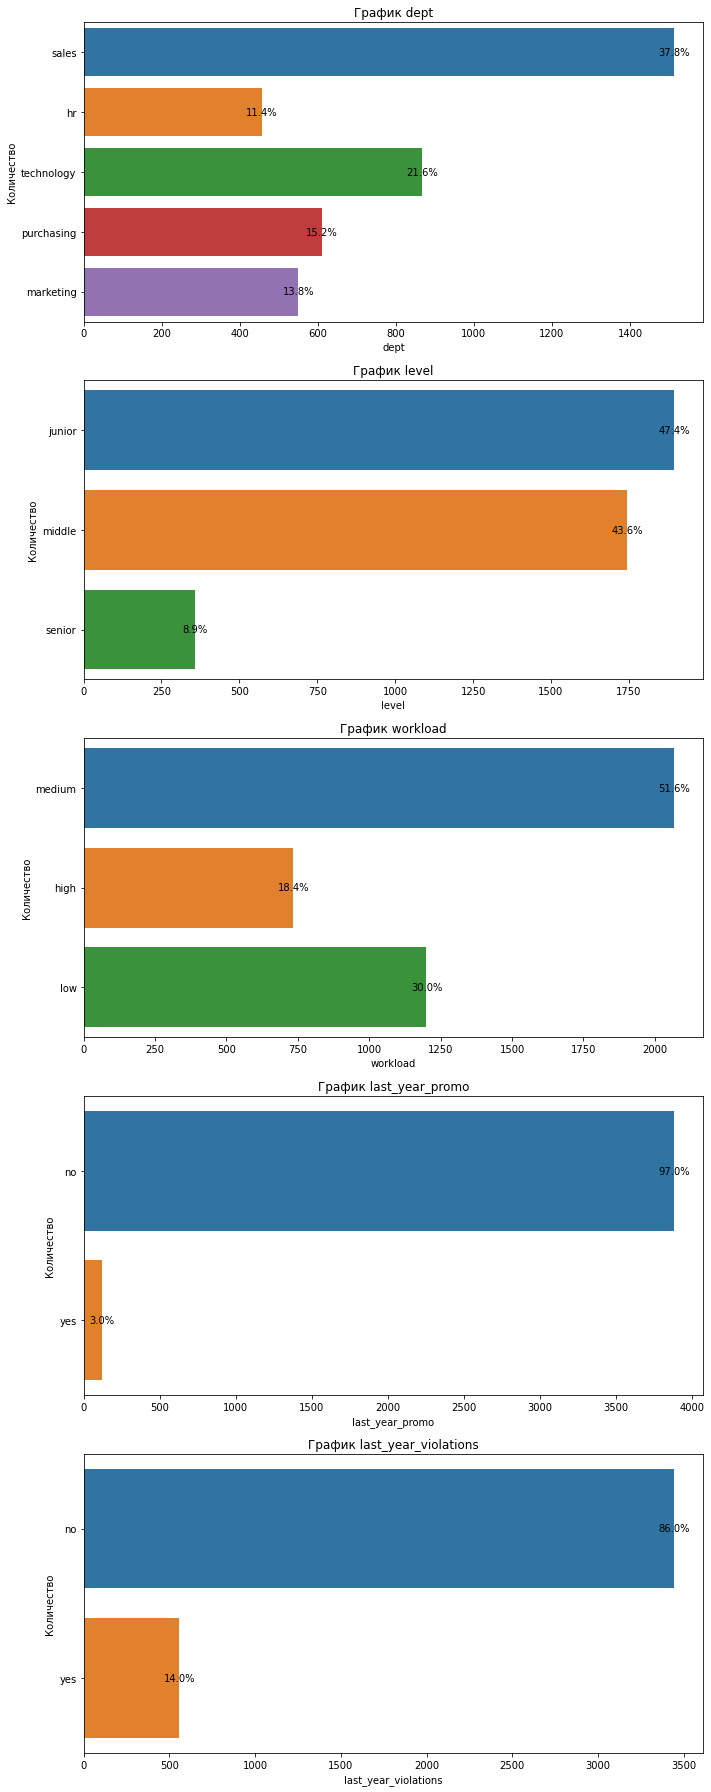

In [28]:
plot_countplots(train)

**Корреляционный анализ**

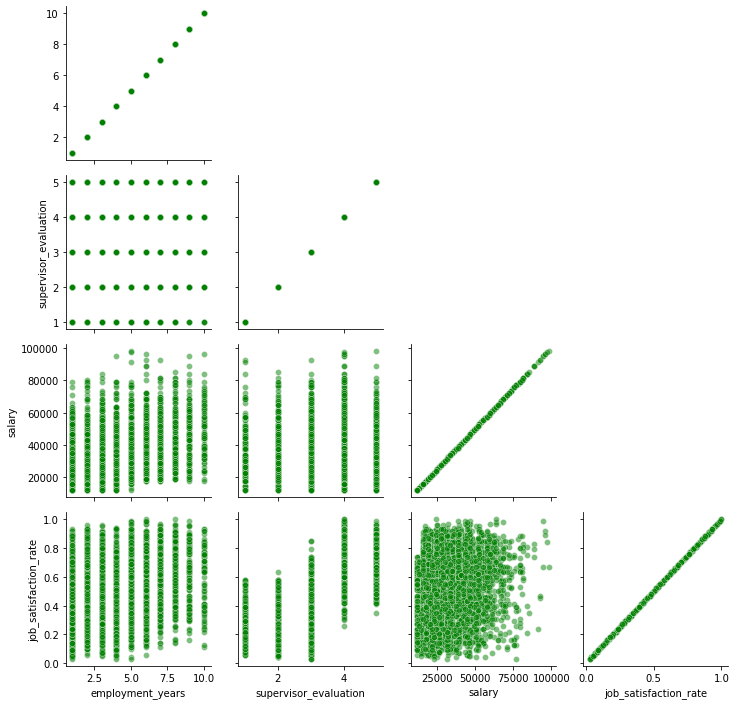

In [29]:
g = sns.PairGrid(train.drop('id', axis=1), diag_sharey=False, corner=True)
g.map(sns.scatterplot, alpha=0.5, color='green')
g.add_legend()
plt.show()

- Чем выше оценка от руководства, тем чаще встречается высокий уровень удовлетворенности работой;
- Первые пять лет не встречается зарплата выше 80000, от 5 до 10 лет стажа не встречается зарплаты ниже 20000;
- Плохие оценки от начальства встречаются у сотрудников с любой зарплатой;
- После первых пяти лет работы растет уровень удовлетворенности работой;

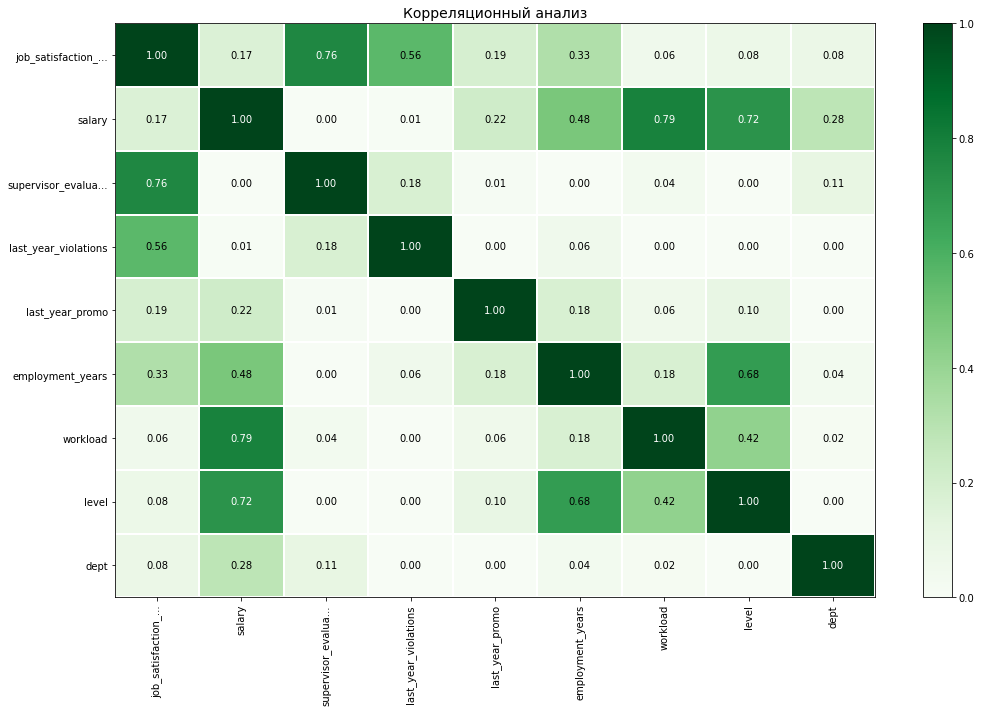

In [30]:
# Создаём список с наименованиями количественных признаков
interval_cols = [
    'employment_years',
    'supervisor_evaluation',
    'salary',
    'job_satisfaction_rate',
]
# Считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(train.drop(['id'], axis=1), interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляционный анализ',
    fontsize_factor=1,
    figsize=(15, 10),
)

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Красивый ковёр задаёт стиль всему проекту! :)

Говоря иначе, молодец, что не забыла выполнить корреляционный анализ.

#### Вывод к EDA:


- Обнаружен дисбаланс классов признака `employment_years`. В компании практически в 2 раза больше сотрудников, которые работают в ней до 3х лет: опытных сотрудников гораздо меньше. Стоит учесть это при переборе параметров для модели в дальнейшем
- Самая частая оценка качества работы сотрудника, которую давал руководитель - 4. 
- Медианная зарплата в компании - **30 000**. На графике видны выбросы, однако убирать их не будем в связи с их небольшим количеством и репрезентативностью высоких зарплат сотрудников. Разброс достаточно велик, поэтому стоит применить масштабирование.
- Целевой признак распределен нормально с двумя пиковыми значениями 
- Больше всего сотрудников **(38%)** заняты в отделе "продаж", однако более всего удовлетворены своим рабочим местом в среднем сотрудники отдела "закупок"
- **47.5%** сотрудников занимают должность `junior`, примерно столько же в компании и специалистов `middle` (**43.6%**). Более всего удовлетворены рабочим местом сотрудники `middle`. 
- Большая часть сотрудников **(51,6%)** имеют среднюю загруженность. 
- Очевидным фактором удовлетворения рабочим местом является повышение в прошлом году или наличие нарушений.
- Сотрудники, которых повысили в прошлом году / которые не получили замечаний за нарушения - гораздо более удовлетворены рабочим местом. 
- Для большинства категориальных признаков будем применять `OneHotEncoder`
- Для признаков `level` и `workload` протестируем `OrdinalEncoder`

---

- *Целевой признак коррелирует умеренно-положительно (0.5 < y < 0.8) с несколькими признаками:*
    - `last_year_violations` - **0.56**. Достаточно очевидно, что полученные замечания за нарушения трудового договора негативно влияют на удовлетворенность сотрудником своим рабочим местом.  
    - `supervisor_evaluation` - **0.76**. Самая высокая корреляция таргета именно с этим признаком. 
- От признаков со слабой корреляцией с таргетом избавляться не будем, так как они могут быть важны при принятии решения модели
- Утечка целевого признака не обнаружена
- Также достаточно очевидно, что уровень зарплаты достаточно сильно зависит от загруженности работник и его отдела 
---

- На графиках видна нелинейная связь целевого признака `job_satisfaction_rate` и коррелирующими признаками `employment_years` и `supervisor_evaluation`. Особенно нельзя описать вид связи таргета и зарплаты сотрудников. Примем это к сведению при моделировании. 

---

### Шаг 4. Подготовка данных

In [31]:
job_X_train=train
job_X_test=test_features
job_y_test=test_target

In [32]:
display(job_X_train.shape)
display(job_X_train.head(2))

(4000, 10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76


In [33]:
display(job_X_test.shape)
display(job_X_test.head(2))

(2000, 9)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000


In [34]:
display(job_y_test.shape)
display(job_y_test.head(2))

(2000, 2)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75


In [35]:
# Убираем таргет из трейна и индексируем выборки
job_X_train_ml = job_X_train.set_index('id')

# Выделяем таргет в тренировочной выборке
job_y_train_ml = job_X_train_ml['job_satisfaction_rate']

job_X_train_ml = job_X_train_ml.drop('job_satisfaction_rate', axis=1)
job_X_test_ml = job_X_test.set_index('id')
job_y_test_ml = job_y_test.set_index('id')
job_full_test = job_X_test_ml.merge(job_y_test_ml, right_index=True, left_index=True)
job_y_test_ml = job_full_test['job_satisfaction_rate']
job_X_test_ml = job_full_test.drop('job_satisfaction_rate', axis=1)

display(job_X_train_ml.head(1))
display(job_X_test_ml.head(1))
display('Количество дубликатов job_X_train после корректировок:', job_X_train_ml.duplicated().sum())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800


'Количество дубликатов job_X_train после корректировок:'

1492

In [36]:
job_X_train_ml.drop_duplicates(inplace=True, ignore_index=False)

# Проверка
display('Количество дубликатов job_X_train после удаления:', job_X_train_ml.duplicated().sum())
display(job_X_train_ml.head())

'Количество дубликатов job_X_train после удаления:'

0

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000
653870,hr,junior,high,2,no,no,5,38400
184592,sales,junior,low,1,no,no,2,12000
171431,technology,junior,low,4,no,no,2,18000
693419,hr,junior,medium,1,no,no,3,22800


In [37]:
display(job_X_train_ml.shape)
display(job_X_test_ml.shape)
display(job_y_train_ml.shape)
display(job_y_test_ml.shape)

(2508, 8)

(2000, 8)

(4000,)

(2000,)

In [38]:
job_y_train_ml = job_y_train_ml[job_y_train_ml.index.isin(job_X_train_ml.index)]
job_y_train_ml.shape

(2508,)

Создаем пайплайн

In [39]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

#Cоздаём пайплайны для подготовки признаков 
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

#Cоздаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
     ],
    remainder='passthrough'
)

#Cоздаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

### Шаг 5. Обучение моделей

#### Создание собственной метрики

Создаем новую метрику SMAPE

**Критерий успеха: SMAPE ≤ 15 на тестовой выборке.**

In [40]:
def smape(y_true, y_pred):

    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
    return np.mean(diff) * 100


# Создаём пользовательскую метрику
smape_score = make_scorer(smape, greater_is_better=False)

Подбор гиперпараметров множества моделей

In [41]:
param_grid_test = [[
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],

    [{
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 21),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],

     [{
        'models': [LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)],
        'models__max_depth': range(1, 21),
        'models__n_estimators': range(10, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],



    [{
        'models': [KNeighborsRegressor(n_jobs=-1, weights='distance')],
        'models__n_neighbors': range(5, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],
]

In [42]:
# Создаем пустые списки для таблицы результатов 
models = []
train_score = []
test_score = []

# Шаблон таблицы результатов
score_table = {
    'model': models,
    'train_SMAPE': train_score,
    'test_SMAPE': test_score,
}

Причины выбора LGBM : LGBM (как градиентный бустинг на деревьях решений) способен обобщать сложные нелинейные зависимости в данных. Он может строить ансамбль деревьев, каждое из которых улучшает ошибки предыдущих, что позволяет модели более точно аппроксимировать сложные функции. 

Поскольку на этапе корреляционного анализа мы выявили нелинейные зависимости, LGBM как никак лучше линейных моделей справится с решением. All in all, LGBM "автоматически" учитывает взаимодействия между признаками, что позволяет лучше адаптироваться к нелинейным зависимостям в данных.

In [43]:
# В цикле переберем по 30 комбинаций гиперпараметров для каждой модели и сохраним результаты в `score_table`
for grid in param_grid_test:
    search = RandomizedSearchCV(
        pipe_final,
        grid,
        n_jobs=-1,
        cv=10,
        n_iter=30,
        scoring=smape_score,
        random_state=RANDOM_STATE
    )

    # Обучаем модель
    search.fit(job_X_train_ml, job_y_train_ml)
    current_best_model = search.best_estimator_['models']
    predictions_test = search.best_estimator_.predict(job_X_test_ml)
    current_train_score = (-1) * search.best_score_
    current_test_score = smape(job_y_test_ml, predictions_test)

    print(current_best_model)
    print('SMAPE лучшей модели на кросс-валидации по обучающей выборке:', current_train_score)
    print(f'SMAPE на тестовой выборке: {current_test_score}')
    print('---')

    # Сохраняем результат итерации
    models.append(current_best_model)
    train_score.append(current_train_score)
    test_score.append(current_test_score)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=30. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


LinearRegression()
SMAPE лучшей модели на кросс-валидации по обучающей выборке: 25.175580466616672
SMAPE на тестовой выборке: 23.514171262326602
---
DecisionTreeRegressor(max_depth=20, min_samples_leaf=4, random_state=42)
SMAPE лучшей модели на кросс-валидации по обучающей выборке: 17.70040624248093
SMAPE на тестовой выборке: 14.043431587948731
---
LGBMRegressor(max_depth=14, n_estimators=97, random_state=42, verbose=-1)
SMAPE лучшей модели на кросс-валидации по обучающей выборке: 13.038491110689893
SMAPE на тестовой выборке: 11.202453523918512
---
KNeighborsRegressor(n_jobs=-1, n_neighbors=6, weights='distance')
SMAPE лучшей модели на кросс-валидации по обучающей выборке: 20.147111803898582
SMAPE на тестовой выборке: 15.133447515668742
---


In [44]:
# Выведем таблицу с результатами
scoring_table = pd.DataFrame(score_table)
scoring_table.sort_values(by='test_SMAPE')

,model,train_SMAPE,test_SMAPE
2,"LGBMRegressor(max_depth=14, n_estimators=97, r...",13.038491,11.202454
1,"DecisionTreeRegressor(max_depth=20, min_sample...",17.700406,14.043432
3,"KNeighborsRegressor(n_jobs=-1, n_neighbors=6, ...",20.147112,15.133448
0,LinearRegression(),25.175580,23.514171


 - Лучшая модель по итогу перебора - `LGBMRegressor(max_depth=20, n_estimators=96,random_state=42)`
 - **SMAPE** на тестовой выборке - `11.072211264327137` - хороший результат!
 - На втором месте - `DecisionTreeRegressor`, а хуже всего справилась `LinearRegression` со значением SMAPE `23.547602` на тестовой выборке
 - Можно дополнительно уточнить параметры LGBMRegressor в коде ниже: вероятно, удастся еще улучшить метрику 

Уточним гиперпараметры для лучшей модели

In [45]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },

    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)],
        'models__max_depth': range(1, 40),
        'models__n_estimators': range(50, 150),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },

]

rs = RandomizedSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    n_iter=50,
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE
)
rs.fit(job_X_train_ml, job_y_train_ml)

print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print('---')
print('SMAPE лучшей модели на кросс-валидации по обучающей выборке:', (-1) * rs.best_score_)

# Проверяем модель на тестовой выборке
job_y_test_pred = rs.best_estimator_.predict(job_X_test_ml)
print(f'SMAPE на тестовой выборке: {smape(job_y_test_ml, job_y_test_pred)}')
print('---')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

- Удалось еще уменьшить метрику на тестовой выборке!
- Лучшая модель: `LGBMRegressor(max_depth=13, n_estimators=145, random_state=42)`
- Лучшее значение метрики на тестовой выборке: ` 10.915527122848754`

#### Анализ важности признаков

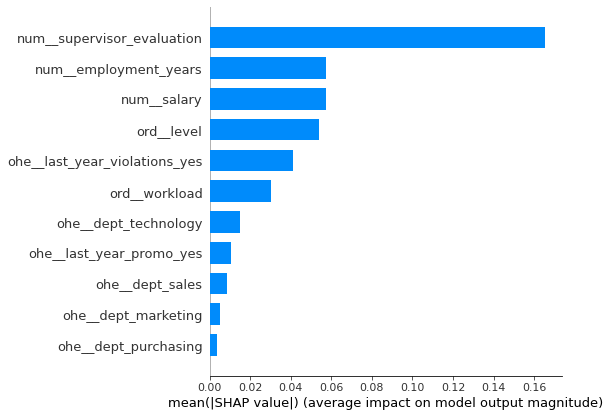

None

In [46]:
# Подготовим данные для SHAP-анализа
model = rs.best_estimator_['models']
preprocessor_pipe = rs.best_estimator_.named_steps['preprocessor']
X_train_scalled = preprocessor_pipe.fit_transform(job_X_train_ml)
X_test_scalled = preprocessor_pipe.transform(job_X_test_ml)
feature_names = rs.best_estimator_[:-1].get_feature_names_out()

# Создаем Explainer
explainer = shap.TreeExplainer(model)

# Получаем SHAP-значения для данных
shap_values = explainer.shap_values(X_test_scalled)

# Визуализиурем важность признаков
display(shap.summary_plot(shap_values, X_test_scalled, feature_names=feature_names, plot_type="bar"))


- Больше всех на предсказания модели влияет признак `supervisor_evaluation`. 
- На втором месте - `employment_years`. 

#### Выводы

-  Сначала  создали собственную метрику - **SMAPE** (симметричное среднее абсолютное процентное отклонение)
- После перебрали гиперпараметры 5-ти моделей в пайплайне при помощи `RandomizedSearchCV`:
    - *LinearRegression*
    - *DecisionTreeRegressor*
    - *LGBMRegressor*
    - *RandomForestRegressor*
    - *KNeighborsRegressor*
    
    
- Отметили, что лучше всего себя показала модель `LGBMRegressor(max_depth=19, n_estimators=77,random_state=42)`
    - **SMAPE** на тестовой выборке - `11.298824391526017`
- Углубленно подобрали гиперпараметры модели `LGBMRegressor`:
    - Наилучшая модель - `LGBMRegressor(max_depth=13, n_estimators=145, random_state=42)`
    - Финальное значение **SMAPE** на тестовой выборке - **`10.915527122848754`**

---
- Причины выбора LGBM :   *LGBM (как градиентный бустинг на деревьях решений)  способен обобщать сложные нелинейные зависимости в данных*. Он может строить ансамбль деревьев, каждое из которых улучшает ошибки предыдущих, что позволяет модели более точно аппроксимировать сложные функции. Поскольку на этапе корреляционного анализа мы выявили нелинейные зависимости, LGBM как никак лучше линейных моделей справится с решением. All in all, LGBM "автоматически" учитывает взаимодействия между признаками, что позволяет лучше адаптироваться к нелинейным зависимостям в данных.

## Задача 2: предсказание увольнения сотрудника из компании

### Шаг 1. Загрузка данных

#### Проверяем данные на соответсвие описанию

In [47]:
job_X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [48]:
quit_X_train = pd.read_csv('/datasets/train_quit.csv')
quit_y_test = pd.read_csv('/datasets/test_target_quit.csv')

In [49]:
quit_X_test = job_X_test_ml.copy(deep=True)

In [50]:
data_info(quit_X_train)

'Первые пять строк данных:'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



-----------------------------



'Последние пять строк данных:'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no
3999,853842,sales,junior,medium,2,no,no,3,27600,yes



-----------------------------



'Общая информация о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB

-----------------------------



'Описание данных:'

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000



-----------------------------



'Количество пропусков'

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64


-----------------------------



'Количество явных дубликатов'

0

In [51]:
data_info(quit_y_test)

'Первые пять строк данных:'

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes



-----------------------------



'Последние пять строк данных:'

,id,quit
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no
1999,460332,yes



-----------------------------



'Общая информация о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB

-----------------------------



'Описание данных:'

,quit
count,2000
unique,2
top,no
freq,1436



-----------------------------



'Количество пропусков'

id      0
quit    0
dtype: int64


-----------------------------



'Количество явных дубликатов'

0

#### Вывод

- `quit_X_train`
    - Всего в датасете 4000 записей
    - Пропущенные значения не обнаружены
    - Явные дубликаты не обнаружены
    - Предварительно, аномальных значений не обнаружено 
    - С типами данных все в порядке

- `quit_y_test`
    - Всего в датасете 2000 записей
    - Пропущенные значения не обнаружены
    - Явные дубликаты не обнаружены
    - Предварительно, аномальных значений не обнаружено 
    - С типами данных все в порядке

### Предоработка

#### Предоработка

In [52]:
[{i: list(quit_X_train[i].unique())} for i in quit_X_train.columns if quit_X_train[i].dtype == 'object']

[{'dept': ['sales', 'purchasing', 'marketing', 'technology', 'hr']},
 {'level': ['middle', 'junior', 'sinior']},
 {'workload': ['high', 'medium', 'low']},
 {'last_year_promo': ['no', 'yes']},
 {'last_year_violations': ['no', 'yes']},
 {'quit': ['no', 'yes']}]

In [53]:
# Исправим орфографическую ошибку для удобства
quit_X_train['level'].replace({'sinior': 'senior'}, inplace=True)

# Проверка
list(quit_X_train['level'].unique())

['middle', 'junior', 'senior']

In [54]:
# Проверим уникальные значения таргета
quit_y_test['quit'].unique()

array(['yes', 'no'], dtype=object)

#### Индексация выборок

In [55]:
quit_y_test = quit_y_test.set_index('id')

In [56]:
quit_X_test = quit_X_test.merge(quit_y_test, right_index=True, left_index=True)
quit_X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no
686555,hr,junior,medium,1,no,no,4,30000,no
467458,sales,middle,low,5,no,no,4,19200,no
418655,sales,middle,low,6,no,no,4,19200,no
789145,hr,middle,medium,5,no,no,5,40800,no


In [57]:
# Кодируем таргет через LabelEncoder
le = LabelEncoder()
le.fit(["no", "yes"])
quit_X_train['quit'] = le.transform(quit_X_train['quit'])
quit_X_test['quit'] = le.transform(quit_X_test['quit'])

In [58]:
display(quit_X_train.head())
display(quit_X_test.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,0
1,814010,sales,junior,medium,2,no,no,4,27600,0
2,155091,purchasing,middle,medium,5,no,no,1,37200,0
3,257132,sales,junior,medium,2,no,yes,3,24000,1
4,910140,marketing,junior,medium,2,no,no,5,25200,0


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0
686555,hr,junior,medium,1,no,no,4,30000,0
467458,sales,middle,low,5,no,no,4,19200,0
418655,sales,middle,low,6,no,no,4,19200,0
789145,hr,middle,medium,5,no,no,5,40800,0


In [59]:
quit_X_train = quit_X_train.set_index('id')
display(quit_X_train.head(1))
display(quit_X_test.head(1))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0


In [60]:
quit_y_test = quit_X_test['quit']
quit_y_test.head()

id
485046    0
686555    0
467458    0
418655    0
789145    0
Name: quit, dtype: int64

- Закодировали  строки "no" и "yes" в столбцах `['last_year_promo', 'last_year_violations', 'quit']`
- Исправили орфографическую ошибку `sinior` в датасете `quit_X_train`
- Проиндексировали выборки

### Исследовательский анализ данных

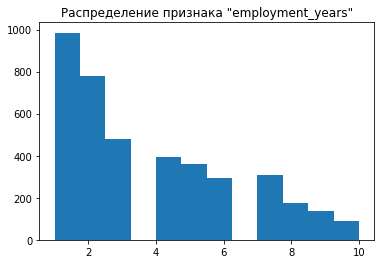

In [61]:
n = quit_X_train['employment_years'].dropna().shape[0]
bins = int(np.log2(n) + 1)
plt.hist(quit_X_train['employment_years'], bins=bins)
plt.title(f'Распределение признака "employment_years"')
plt.show()

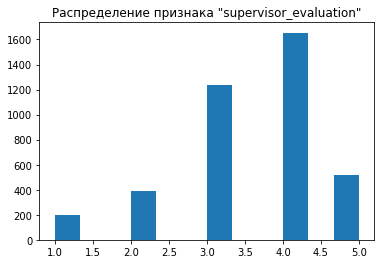

In [62]:
n = quit_X_train['supervisor_evaluation'].dropna().shape[0]
bins = int(np.log2(n) + 1)
plt.hist(quit_X_train['supervisor_evaluation'], bins=bins)
plt.title(f'Распределение признака "supervisor_evaluation"')
plt.show()

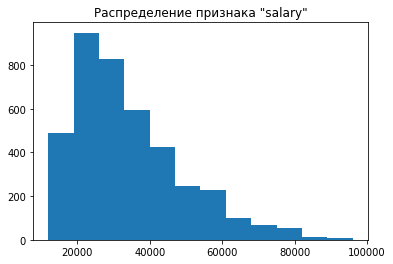

In [63]:
n = quit_X_train['salary'].dropna().shape[0]
bins = int(np.log2(n) + 1)
plt.hist(quit_X_train['salary'], bins=bins)
plt.title(f'Распределение признака "salary"')
plt.show()

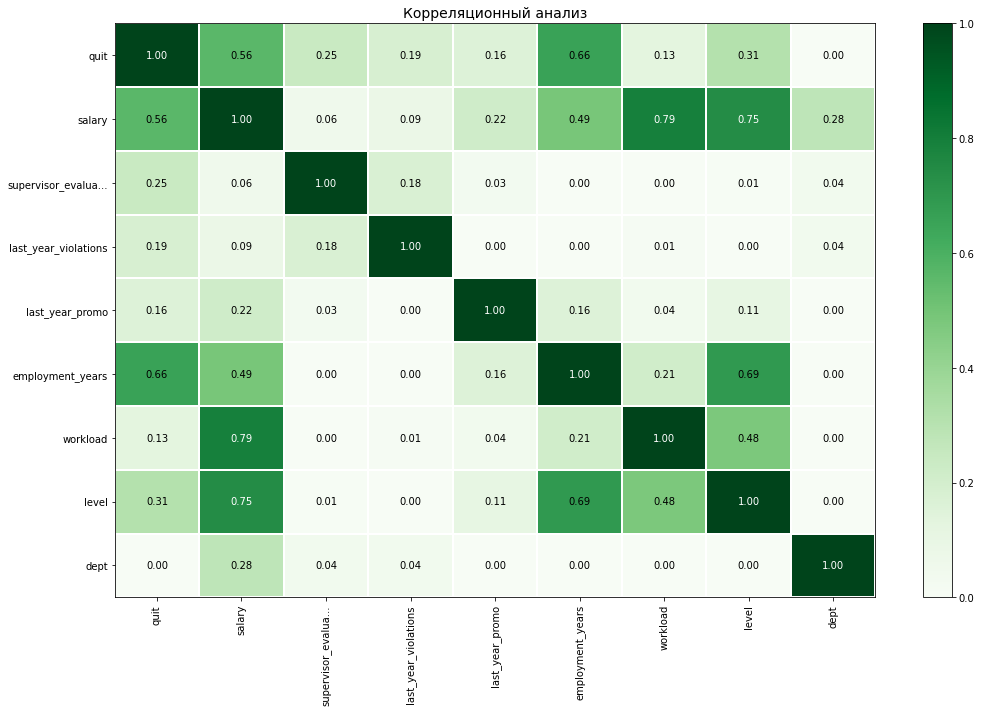

In [64]:
interval_cols = [
    'employment_years',
    'supervisor_evaluation',
    'salary',
]

# Считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(quit_X_train, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляционный анализ',
    fontsize_factor=1,
    figsize=(15, 10),
)

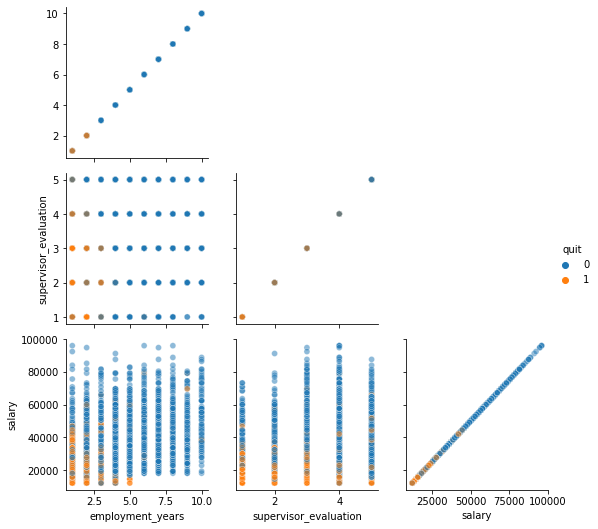

In [65]:
# Построим графики зависимостей признаков
g = sns.PairGrid(quit_X_train, diag_sharey=False, corner=True, hue='quit')
g.map(sns.scatterplot, alpha=0.5)
g.add_legend()
plt.show()

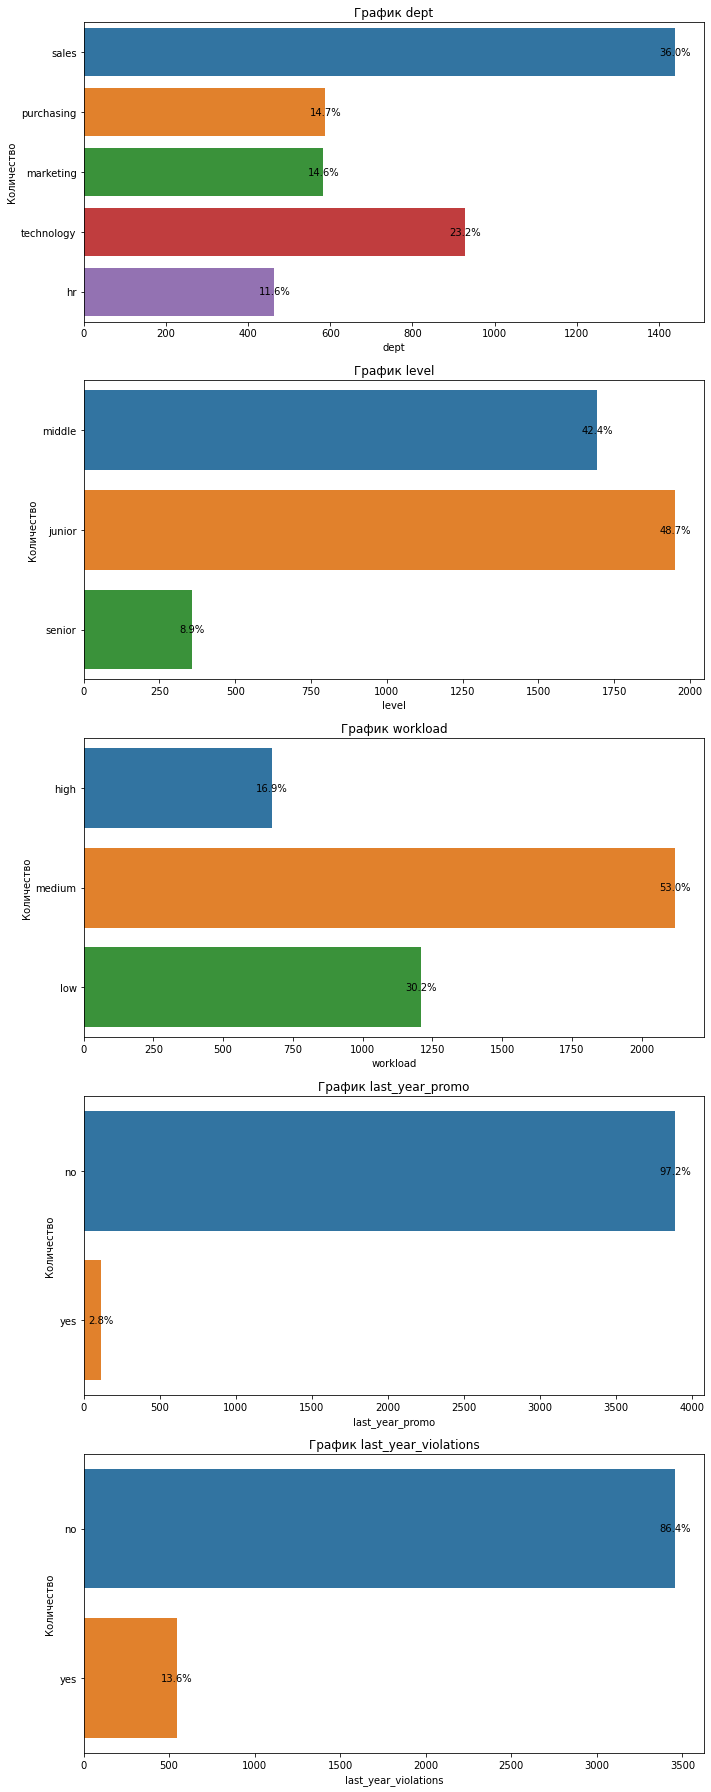

In [66]:
plot_countplots(quit_X_train)

#### Выводы к EDA

- В целом, распределение признаков весьма схоже с предыдущими данными. Ключевые моменты:
    - Сильный дисбаланс по повышению сотрудников: `97.2%` сотрудников НЕ были повышены
    - Только `13.6%` сотрудников получили выговоры за нарушения ТК в прошлом году
    - `71.8%` НЕ были уволены из компании по существующим данным. Имеем дело с дисбалансом целевого признака. 
---
- *Целевой признак коррелирует умеренно-положительно (0.5 < y < 0.8) с несколькими признаками:*
    - `employment_years` - **0.66**. Более всего сотрудников увольняются до 2-х лет работы в компании. Это связано с классической текучкой и описывается нормальным явлением.  
    - `salary` - **0.51**. Подобная корреляция связана с уровнем ЗП сотрудников: чем она ниже (и, вероятно, не соответствует ожиданиям сотрудников) - тем охотнее увольняются работники.
- Утечка целевого признака не обнаружена
- Также достаточно очевидно, что уровень зарплаты достаточно сильно зависит от загруженности работник и его отдела 


### Портрет "уволившегося сотрудника"

In [67]:
resigned = quit_X_train.query('quit == 1')
not_resigned = quit_X_train.query('quit == 0')
resigned.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
257132,sales,junior,medium,2,no,yes,3,24000,1
699916,sales,junior,low,1,no,yes,3,18000,1
613206,technology,middle,medium,2,no,no,3,45600,1
468145,technology,junior,medium,2,no,no,3,30000,1
982346,marketing,junior,medium,3,no,no,3,30000,1


In [68]:
resigned['dept'].value_counts()

sales         407
technology    276
purchasing    166
marketing     163
hr            116
Name: dept, dtype: int64

In [69]:
not_resigned['dept'].value_counts()

sales         1031
technology     652
purchasing     422
marketing      419
hr             348
Name: dept, dtype: int64

In [70]:
resigned['level'].value_counts()

junior    1003
middle     108
senior      17
Name: level, dtype: int64

In [71]:
not_resigned['level'].value_counts()

middle    1586
junior     946
senior     340
Name: level, dtype: int64

In [72]:
resigned['workload'].value_counts()

low       519
medium    488
high      121
Name: workload, dtype: int64

In [73]:
not_resigned['workload'].value_counts()

medium    1630
low        689
high       553
Name: workload, dtype: int64

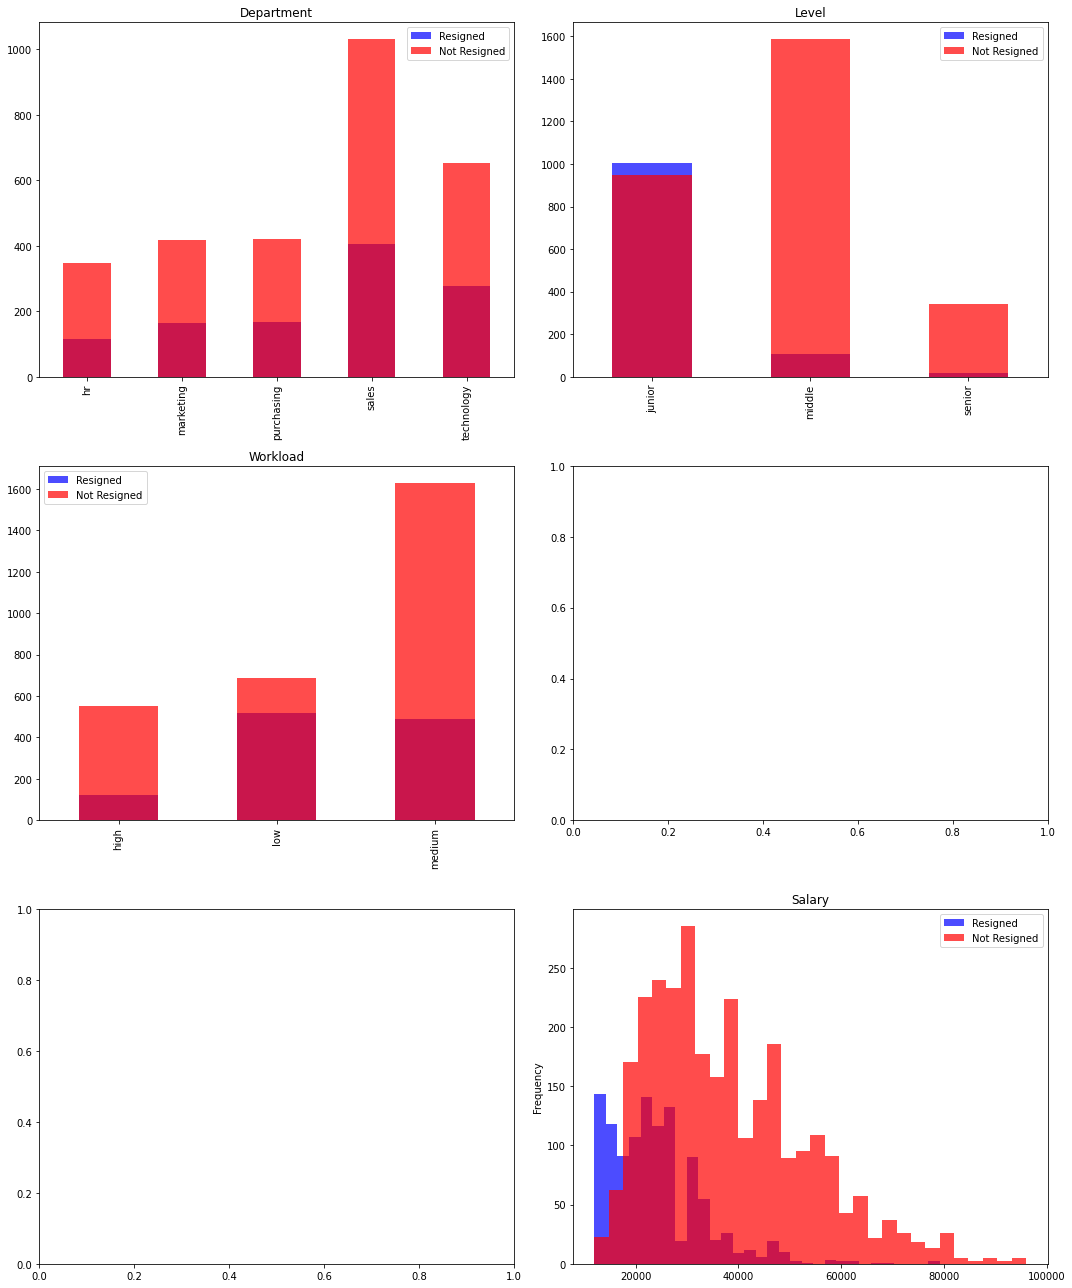

In [74]:
fig, axs = plt.subplots(3, 2, figsize=(15, 18))

# Графики для 'dept'
resigned['dept'].value_counts().sort_index().plot(kind='bar', ax=axs[0, 0], color='blue', alpha=0.7, label='Resigned')
not_resigned['dept'].value_counts().sort_index().plot(kind='bar', ax=axs[0, 0], color='red', alpha=0.7, label='Not Resigned')
axs[0, 0].set_title('Department')
axs[0, 0].legend()

# Графики для 'level'
resigned['level'].value_counts().sort_index().plot(kind='bar', ax=axs[0, 1], color='blue', alpha=0.7, label='Resigned')
not_resigned['level'].value_counts().sort_index().plot(kind='bar', ax=axs[0, 1], color='red', alpha=0.7, label='Not Resigned')
axs[0, 1].set_title('Level')
axs[0, 1].legend()

# Графики для 'workload'
resigned['workload'].value_counts().sort_index().plot(kind='bar', ax=axs[1, 0], color='blue', alpha=0.7, label='Resigned')
not_resigned['workload'].value_counts().sort_index().plot(kind='bar', ax=axs[1, 0], color='red', alpha=0.7, label='Not Resigned')
axs[1, 0].set_title('Workload')
axs[1, 0].legend()

# Графики для 'salary'
resigned['salary'].plot(kind='hist', ax=axs[2, 1], color='blue', alpha=0.7, bins=30, label='Resigned')
not_resigned['salary'].plot(kind='hist', ax=axs[2, 1], color='red', alpha=0.7, bins=30, label='Not Resigned')
axs[2, 1].set_title('Salary')
axs[2, 1].legend()

plt.tight_layout()
plt.show()


In [75]:
print('Среднее время работы уволившегося сотрудника в компании:', resigned['employment_years'].mean())

Среднее время работы уволившегося сотрудника в компании: 1.8448581560283688


In [76]:
print('Средняя ЗП уволившихся сотрудников:', resigned['salary'].median())
print('Средняя ЗП работающих сотрудников:', not_resigned['salary'].median())
print('Средняя разница в зарплатах:', not_resigned['salary'].median() - resigned['salary'].median())

Средняя ЗП уволившихся сотрудников: 22800.0
Средняя ЗП работающих сотрудников: 34800.0
Средняя разница в зарплатах: 12000.0


**Портрет уволившегося сотрудника:**
- Скорее всего работает в отделе продаж (sales)
- Имеет низшую должность (junior)
- Имеет низкую / среднюю загруженность
- В среднем проработал 1-2 года в компании
- В среднем зарабатывает *22 800* (что на 12 000 меньше среднего уровня ЗП остальных сотрудников)
- Доля ушедших сотрудников - `28.2%` 

#### Проверка гипотезы: *Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.*

In [77]:
target_dependence = job_y_test.merge(quit_y_test, on='id', how='left')
target_dependence.head()

,id,job_satisfaction_rate,quit
0,130604,0.74,0
1,825977,0.75,0
2,418490,0.60,1
3,555320,0.72,0
4,826430,0.08,1


In [78]:
target_dependence_resigned = target_dependence.query('quit == 1')['job_satisfaction_rate']
target_dependence_not_resigned = target_dependence.query('quit == 0')['job_satisfaction_rate']
display(len(target_dependence_resigned))
display(len(target_dependence_not_resigned))

564

1436

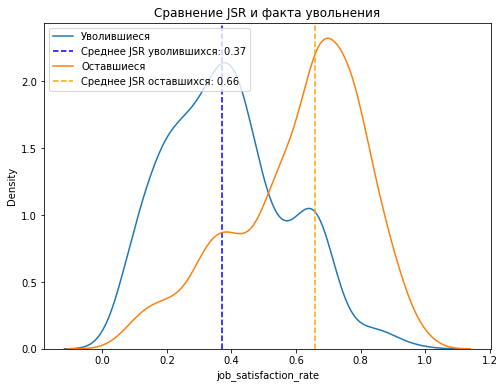

In [79]:
fig, axes = plt.subplots(figsize=(8, 6))

# График №1
sns.kdeplot(
    data=target_dependence_resigned,
    label='Уволившиеся',
    ax=axes
)

# Медиана для графика №1
mean_resigned = target_dependence_resigned.median()
axes.axvline(
    mean_resigned,
    color='blue',
    linestyle='--',
    label=f'Среднее JSR уволившихся: {mean_resigned:.2f}'
)

# График №2
sns.kdeplot(
    data=target_dependence_not_resigned,
    label='Оставшиеся',
    ax=axes
)

# Медиана для графика №2
mean_not_resigned = target_dependence_not_resigned.median()
axes.axvline(
    mean_not_resigned,
    color='orange', linestyle='--',
    label=f'Среднее JSR оставшихся: {mean_not_resigned:.2f}'
)

axes.set_title('Сравнение JSR и факта увольнения')
plt.legend(loc='upper left')
plt.show()

In [80]:
print('Среднее JSR уволившихся сотрудников:', target_dependence_resigned.mean())
print('Среднее JSR оставшихся сотрудников:', target_dependence_not_resigned.mean())

Среднее JSR уволившихся сотрудников: 0.38771276595744686
Среднее JSR оставшихся сотрудников: 0.6120403899721449


**Действительно**, уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник или нет. JSR уволившихся сотрудников практически в 2 раза ниже оставшихся (в среднем - `0.39` по отношению к `0.61`)

#### Добавление нового входного признака

Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [81]:
job_X_train_merge = job_X_train.set_index('id')
job_X_train_merge.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58


In [82]:
# Проверим, есть ли схожие ID работников в обучающих датасетах
common_ids = set(quit_X_train.index).intersection(set(job_X_train_merge.index))
print("Общие 'id':", len(common_ids))

Общие 'id': 0


Общих ID не обнаружено. В таком случае, мы **не можем** добавлять значения JSR из `job_X_train` напрямую. 

Предскажем JSR для сотрудников датасета `quit_X_train`:

In [83]:
quit_train_JSR = rs.best_estimator_.predict(quit_X_train)
quit_train_JSR

array([0.66081266, 0.82446973, 0.31733654, ..., 0.55144567, 0.54115401,
       0.59092071])

In [84]:
quit_X_train_ml = quit_X_train.copy(deep=True)
quit_X_train_ml['job_satisfaction_rate'] = quit_train_JSR
quit_X_train_ml.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0,0.660813
814010,sales,junior,medium,2,no,no,4,27600,0,0.824470
155091,purchasing,middle,medium,5,no,no,1,37200,0,0.317337
257132,sales,junior,medium,2,no,yes,3,24000,1,0.352616
910140,marketing,junior,medium,2,no,no,5,25200,0,0.749794


Что касается тестовой выборки - мы скопировали входные признаки из `job_X_train`, поэтому имеем право добавить те предсказанные значения, которые уже записали в переменной `job_y_test_pred`

In [85]:
# Проверим, количество схожих ID работников в тестовых датасетах
common_ids = set(quit_X_test.index).intersection(set(job_X_test_ml.index))
print(len(quit_X_test))
print(len(job_X_test_ml))
print("Общие 'id':", len(common_ids))

2000
2000
Общие 'id': 2000


In [86]:
quit_X_test_ml = quit_X_test.copy(deep=True)
quit_X_test_ml['job_satisfaction_rate'] = job_y_test_pred
quit_X_test_ml.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0,0.877741
686555,hr,junior,medium,1,no,no,4,30000,0,0.664997
467458,sales,middle,low,5,no,no,4,19200,0,0.656423
418655,sales,middle,low,6,no,no,4,19200,0,0.633266
789145,hr,middle,medium,5,no,no,5,40800,0,0.784968


#### Подготовка признаков

Корректируем тренировочную и тестовую выборки

In [87]:
# Выделяем таргет в тренировочной выборке
quit_y_train_ml = quit_X_train_ml['quit']

# Убираем таргет из трейна и грамотно индексируем выборки
quit_X_train_ml = quit_X_train_ml.drop('quit', axis=1)
#quit_X_test_full = quit_X_test_ml.merge(quit_y_test, right_index=True, left_index=True)
quit_y_test_ml = quit_X_test['quit']
quit_X_test_ml = quit_X_test_ml.drop('quit', axis=1)

display(quit_X_train_ml.head(1))
display(quit_X_train_ml.shape)
print('---')
display(quit_y_train_ml.head(5))
display(quit_y_train_ml.shape)
print('---')
display(quit_X_test_ml.head(1))
display(quit_X_test_ml.shape)
print('---')
display(quit_y_test_ml.head(5))
display(quit_y_test_ml.shape)
print('---')
display('Количество дубликатов quit_X_train_ml после корректировок:', quit_X_train_ml.duplicated().sum())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.660813


(4000, 9)

---


id
723290    0
814010    0
155091    0
257132    1
910140    0
Name: quit, dtype: int64

(4000,)

---


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.877741


(2000, 9)

---


id
485046    0
686555    0
467458    0
418655    0
789145    0
Name: quit, dtype: int64

(2000,)

---


'Количество дубликатов quit_X_train_ml после корректировок:'

1545

In [88]:
quit_X_train_ml.drop_duplicates(inplace=True, ignore_index=False)

# Проверка
display('Количество дубликатов quit_X_train_ml после удаления:', quit_X_train_ml.duplicated().sum())
display(quit_X_train_ml.head())
display(quit_X_train_ml.shape)

quit_y_train_ml = quit_y_train_ml[quit_y_train_ml.index.isin(quit_X_train_ml.index)]
quit_y_train_ml.shape

'Количество дубликатов quit_X_train_ml после удаления:'

0

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.660813
814010,sales,junior,medium,2,no,no,4,27600,0.824470
155091,purchasing,middle,medium,5,no,no,1,37200,0.317337
257132,sales,junior,medium,2,no,yes,3,24000,0.352616
910140,marketing,junior,medium,2,no,no,5,25200,0.749794


(2455, 9)

(2455,)

Обновляем пайплайн

In [89]:
# Добавляем новый признак в preprocessor
num_columns.append('job_satisfaction_rate')
#ohe_columns.append('quit')

# Обновляем модель в итоговом пайплайне
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

### Обучение моделей

Подбор гиперпараметров множества моделей

In [90]:
param_grid_test_2 = [
    [{
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='liblinear')],
        'models__penalty': ['l1', 'l2'],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],

    [{
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 21),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],

    [{
        'models': [LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)],
        'models__max_depth': range(1, 21),
        'models__n_estimators': range(80, 120),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],

   


    [{
        'models': [KNeighborsClassifier(n_jobs=-1, weights='distance')],
        'models__n_neighbors': range(5, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],
]

In [ ]:
models_clf = []
train_score_clf = []
test_score_clf = []
best_score_clf = 0

score_table_clf = {
    'model': models_clf,
    'train_roc_auc': train_score_clf,
    'test_roc_auc': test_score_clf,
}

# В цикле переберем по 30 комбинаций гиперпараметров для каждой модели и сохраним результаты в `score_table`
for grid in param_grid_test_2:
    search_class = RandomizedSearchCV(
        pipe_final_2,
        grid,
        n_jobs=-1,
        cv=10,
        n_iter=50,
        scoring='roc_auc',
        random_state=RANDOM_STATE
    )

    # Обучаем модель
    search_class.fit(quit_X_train_ml, quit_y_train_ml)
    current_best_model = search_class.best_estimator_['models']
    predictions_test = search_class.best_estimator_.predict(quit_X_test_ml)
    quit_predictions = search_class.best_estimator_.predict_proba(quit_X_test_ml)[:, 1]
    current_train_score = search_class.best_score_
    current_test_score = roc_auc_score(quit_y_test_ml, quit_predictions)

    print('Модель и её лучшие гиперпараметры:\n\n', current_best_model)
    print('ROC-AUC лучшей модели на кросс-валидации по обучающей выборке:', current_train_score)
    print(f'ROC-AUC на тестовой выборке: {current_test_score}')
    print('---')

    # Сохраняем результат итерации
    models_clf.append(current_best_model)
    train_score_clf.append(current_train_score)
    test_score_clf.append(current_test_score)

    # Сохраняем данные для анализа важности
    if current_test_score > best_score_clf:
        best_score_clf = current_test_score
        best_model_clf = current_best_model
        preprocess_params = search_class.best_estimator_.named_steps['preprocessor']
        feature_names_2 = search_class.best_estimator_[:-1].get_feature_names_out()
    

Модель и её лучшие гиперпараметры:

 LogisticRegression(C=1, class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear')
ROC-AUC лучшей модели на кросс-валидации по обучающей выборке: 0.9208446847164456
ROC-AUC на тестовой выборке: 0.9039917076591794
---
Модель и её лучшие гиперпараметры:

 DecisionTreeClassifier(max_depth=5, random_state=42)
ROC-AUC лучшей модели на кросс-валидации по обучающей выборке: 0.9171371301232485
ROC-AUC на тестовой выборке: 0.9161351221873211
---


In [ ]:
scoring_table_clf = pd.DataFrame(score_table_clf)
scoring_table_clf.sort_values(by='test_roc_auc', ascending=False)

- Лучшая модель по версии `RandomizedSearchCV` - `LGBMClassifier(max_depth=2, n_estimators=112, random_state=42))`
                                        
- **ROC-AUC** на тестовой выборке - ` 0.9307047501926154` 

#### Анализ важности признаков

In [ ]:
# Подготовим данные для SHAP-анализа
X_train_scalled_2 = preprocess_params.fit_transform(quit_X_train_ml)
X_test_scalled_2 = preprocess_params.transform(quit_X_test_ml)

# Создаем Explainer
explainer = shap.TreeExplainer(best_model_clf)

# Получаем SHAP-значения для данных
shap_values = explainer.shap_values(X_test_scalled_2)

# Визуализиурем важность признаков
display(shap.summary_plot(shap_values, X_test_scalled_2, feature_names=feature_names_2))

- Признак `employment_years` оказывает значительное влияние на решения модели. Примерно такой же вес имеет признак `level`. Получается, что два этих показателя являются ключевыми при решении сотрудника **"уволиться"**

#### Вывод

- Перебрали гиперпараметры моделей в пайплайне при помощи `RandomizedSearchCV`:
    - *LogisticRegression*
    - *DecisionTreeClassifier*
    - *LGBMClassifier*
    - *KNeighborsClassifier*
- После перебора нашли лучшую модель: `LGBMClassifier(max_depth=3, n_estimators=107,random_state=42)`
    - **ROC-AUC** на тестовой выборке - `0.9315332434461367`
 
LGBM отлично справляется с дисбалансом классов, что особенно важно для данной задачи классификации.     

### Вывод

**В ходе работы над проектом были решены две ключевые задачи: регрессии и классификации. Были созданы , протестированы и выбраны 2 лучшие модели, которые успешно прошли порог оценки качества**

---

**--ПРЕДСКАЗАНИЕ УРОВНЯ УДОВЛЕТВОРЕННОСТИ СОТРУДНИКА--**

---

Исследование было разделено на несколько этапов:

**1. Загрузка и подготовка данных**

- **`job_X_train`**
    - Всего в датасете 4000 записей
    - Обнаружили пропущенные значения в столбцах `dept` (6) и `level` (4)
    - Явные дубликаты не были обнаружены
    - С типами данных все в порядке

- **`job_X_test`**
    - Всего в датасете 2000 записей
    - Нашли пропущенные значения в столбцах `dept` (2) и `level` (1)
    - Явные дубликаты не были обнаружены
    - С типами данных все в порядке


- **`job_y_test`**
    - Всего в датасете 2000 записей
    - Пропущенных значений не обнаружено
    - Явные дубликаты не обнаружены 
    - С типами данных все в порядке
    

**2. Предобработка данных**


- **`job_X_train`**:
    - Исправили орфографическую ошибку *sinior -> senior* в столбце `level`
    - Заменили пропущенные значения при помощи пайплайна (`SimpleImputer`)

- **`job_X_test`**:
    - Исправили орфографическую ошибку *sinior -> senior* в столбце `level`
    - Заменили пустые строки (" ") из данных на пропущенные значения
    - Заменили пропущенные значения при помощи пайплайна (`SimpleImputer`)


- **`job_y_test`**:
    - С датасетом все в порядке


**3. Исследовательский анализ данных**

- В компании практически в 2 раза больше сотрудников, которые работают в ней до 3х лет: опытных сотрудников гораздо меньше. Стоит учесть это при переборе параметров для модели в дальнейшем
- Самая частая оценка качества работы сотрудника, которую давал руководитель - 4. 
- Медианная зарплата в компании - **30 000**. 
- Больше всего сотрудников **(38%)** заняты в отделе "продаж", однако более всего удовлетворены своим рабочим местом в среднем сотрудники отдела "закупок"
- **47.5%** сотрудников занимают должность `junior`, примерно столько же в компании и специалистов `middle` (**43.6%**). Более всего удовлетворены рабочим местом сотрудники `middle`. 
- Большая часть сотрудников **(51,6%)** имеют среднюю загруженность. 
- Очевидным фактором удовлетворения рабочим местом является повышение в прошлом году или наличие нарушений.
- Сотрудники, которых повысили в прошлом году / которые не получили замечаний за нарушения - гораздо более удовлетворены рабочим местом.
- Уровень зарплаты достаточно сильно зависит от загруженности работник и его отдела.
- Был проведен корреляционный анализ:
    - *Целевой признак коррелирует умеренно-положительно (0.5 < y < 0.8) с несколькими признаками:*
        - `last_year_violations` - **0.56**. Достаточно очевидно, что полученные замечания за нарушения трудового договора негативно влияют на удовлетворенность сотрудником своим рабочим местом.  
        - `supervisor_evaluation` - **0.76**. Самая высокая корреляция таргета именно с этим признаком. 
        - От признаков со слабой корреляцией решили не избавляться, так как они могут быть важны при принятии решения модели

- Построили дополнительные графики и обнаружили нелинейную связь `job_satisfaction_rate` с коррелирующими признаками `employment_years` и `supervisor_evaluation`. Особенно интересен вид связи целевого признака и зарплаты сотрудников. Учли данный факт при моделировании


**4. Подготовка признаков**
- Проиндексировали выборки и почистили их для дальнейшей работы
- Создали полный пайплайн с предобработкой, где применили кодирование и масштабирование при помощи `OneHotEncoder`, `OrdinalEncoder`, `StandardScaler` / `MinMaxScaler`

**5. Обучение моделей**

- Создали собственную метрику - **SMAPE** (симметричное среднее абсолютное процентное отклонение)
- После перебрали гиперпараметры 4-х моделей в цикле через пайплайн при помощи `RandomizedSearchCV`:
    - *LinearRegression*
    - *DecisionTreeRegressor*
    - *LGBMRegressor*
    - *KNeighborsRegressor*

    
- По итогу перебора в цикле, лучше всего себя показала модель `LGBMRegressor(max_depth=20, n_estimators=96,random_state=42)`. 
    - **SMAPE** лучшей модели на тестовой выборке - `11.072211264327137`
- На втором месте - `DecisionTreeRegressor`, а хуже всего справилась `LinearRegression` со значением SMAPE `23.547602` на тестовой выборке
    
    
- Углубленно подобрали гиперпараметры модели `LGBMRegressor`:
    - Лучшая модель - `LGBMRegressor(max_depth=13, n_estimators=145, random_state=42)`
    - Финальное значение **SMAPE** на тестовой выборке - **`10.915527122848754`**
    
    
- Проанализировали важность признаков при помощи `SHAP`:

    - Сильнее других на предсказания модели влияет признак `supervisor_evaluation`. 
    - На втором месте - `employment_years`. 


    

---
**--ПРЕДСКАЗАНИЕ УВОЛЬНЕНИЯ СОТРУДНИКА ИЗ КОМПАНИИ--**

---

Исследование было разделено на несколько этапов:

**1. Загрузка и подготовка данных**
- **`quit_X_train`**
    - С датасетом все в порядке

- **`quit_y_test`**
    - С датасетом все в порядке
    
- Датасет **`quit_X_test`** - копия обработанного датасета с входными признаками предыдущей задачи (`job_X_test_ml`)
    


**2. Предобработка данных**


- Исправили орфографическую ошибку `sinior` в датасете `quit_X_train`
- Проиндексировали выборки

**3. Исследовательский анализ данных**

- *Общий анализ данных:*
    - Сильный дисбаланс по повышению сотрудников: `97.2%` сотрудников НЕ были повышены
    - Только `13.6%` сотрудников получили выговоры за нарушения ТК в прошлом году
    - `71.8%` НЕ были уволены из компании по существующим данным
    - *Целевой признак коррелирует умеренно-положительно (0.5 < y < 0.8) с несколькими признаками:*
        - `employment_years` - **0.66**. Более всего сотрудников увольняются до 2-х лет работы в компании. Это связано с классической текучкой и описывается нормальным явлением.  
        - `salary` - **0.51**. Подобная корреляция связана с уровнем ЗП сотрудников: чем она ниже (и, вероятно, не соответствует ожиданиям сотрудников) - тем охотнее увольняются работники.
    
    
- *Портрет "уволившегося" сотрудника*:
    - Скорее всего работает в отделе продаж (sales)
    - Имеет низшую должность (junior)
    - Имеет низкую / среднюю загруженность
    - В среднем проработал 1-2 года в компании
    - В среднем зарабатывает *22 800* (что на 12 000 меньше среднего уровня ЗП остальных сотрудников)
    
    
- **Подтвердили**, *что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник или нет. JSR уволившихся сотрудников практически в 2 раза ниже оставшихся (в среднем - `0.39` по отношению к `0.61`)*


**4. Добавление нового входного признака**
- Добавили новый входной признак - "удовлетворенность сотрудника работой". 
- Данный признак был добавлен в виде предсказаний модели из задачи номер 1:
    - Проверили грамотность добавления нового признака
    - Получили предсказания модели для новых данных
    - Вставили предсказания в качестве нового признака


**5. Подготовка признаков**
- Скорректировали выборки
- Добавили новый признак `job_satisfaction_rate` в `num_columns` для пайплайна `data_preprocessor`


**6. Обучение моделей**
- Сначала перебрали гиперпараметры моделей в пайплайне при помощи `RandomizedSearchCV`:
    - *LogisticRegression*
    - *DecisionTreeClassifier*
    - *LGBMClassifier*
    - *KNeighborsClassifier*
    

- Лучшая модель по версии `RandomizedSearchCV` - `LGBMClassifier(max_depth=2, n_estimators=112, random_state=42))`
                                        
- **ROC-AUC** на тестовой выборке - ` 0.9307047501926154`

    
- Проанализировали важность признаков при помощи `SHAP`:


- Признак `employment_years` оказывает значительное влияние на решения модели. Примерно такой же вес имеет признак `level`. Получается, что два этих показателя являются ключевыми при решении сотрудника **"уволиться"**



---

**--РЕКОМЕНДАЦИИ ДЛЯ КЛИЕНТА--**

---

- Стоит обращать внимание на то, как оценивается труд сотрудников. Они принимают это достаточно близко к сердцу, что точно сказывается на их удовлетворенности рабочим местом
- Стоит внимательно посмотреть на отдел продаж и зарплаты сотрудников. Вероятно, нужно обратить внимание на "фиксацию" сотрудников в отделе продаж на какой-то более длительный период. Может быть, стоит нормировать график, добавив дистанционные часы
- Удовлетворенность работой - ключевой параметр при увольнении сотрудников, поэтому нужно максимизировать "удрвлетворение" сотрудников от их деятельности. В таком случае, отток действительно может снизиться
